# CNN for Pneumonia Detection from X-Ray Chest Images

This project aims to develop a neural network to identify pneumonia disease from a series of X-Ray images of lungs. The training data consists of two sets of images, one for healthy cases and another one with diagnosed pneumonia. Based on these images, a CNN is created for feature extraction and diagnosis classification. Additionally, two test sets of images are provided including the information of the diagnosis. Taking into account that the test data already reveals the expected target we aim to compute, it will be used as validation data for the assessment of the model.

<img src='./XRay_1.jpg'  align = 'center'>

## Table of Contents

1. Load Train and Test Data
2. Data Exploration
3. Data Preparation
4. CNN Model
5. Model Evaluation

# 1. Load Train and Test Data

We first load the necessary packages which will be used:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.utils import shuffle
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping

Now we define the paths to the train and test files:

In [2]:
cwd = os.getcwd()
path_train_normal = os.path.abspath(cwd + '/ChestXRay2017/chest_xray/train/NORMAL')
path_train_pneumonia = os.path.abspath(cwd + '/ChestXRay2017/chest_xray/train/PNEUMONIA')

path_test_normal = os.path.abspath(cwd + '/ChestXRay2017/chest_xray/test/NORMAL')
path_test_pneumonia = os.path.abspath(cwd + '/ChestXRay2017/chest_xray/test/PNEUMONIA')

A function is used in order to fetch the files from the respective paths:

In [3]:
def get_files(path):
    file_list= []

    for file in os.listdir(path):
        file_list.append(os.path.abspath(path+'/'+file))
    
    return file_list

files_train_normal = get_files(path_train_normal)
files_train_pneumonia = get_files(path_train_pneumonia)

files_test_normal = get_files(path_test_normal)
files_test_pneumonia = get_files(path_test_pneumonia)

The files representing a healthy state are gathered in a dataframe with pneumonia value of 0 representing the absence of it:

In [4]:
df_train_normal = pd.DataFrame(list(zip(files_train_normal, [0,]*len(files_train_normal))), columns = ['image', 'pneumonia'])
df_test_normal = pd.DataFrame(list(zip(files_test_normal, [0,]*len(files_test_normal))), columns = ['image', 'pneumonia'])

We do the same thing with the files reprenting pneumonia. In this case, we set pneumonia value to 1 representing positive diagnosis: 

In [5]:
df_train_pneumonia = pd.DataFrame(list(zip(files_train_pneumonia, [1,]*len(files_train_pneumonia))), columns = ['image', 'pneumonia'])
df_test_pneumonia = pd.DataFrame(list(zip(files_test_pneumonia, [1,]*len(files_test_pneumonia))), columns = ['image', 'pneumonia'])

Finally, we join both dataframes into a single training one:

In [6]:
df_train = pd.concat([df_train_normal, df_train_pneumonia])
df_train.columns = ['image', 'pneumonia']

In [7]:
df_test = pd.concat([df_test_normal, df_test_pneumonia])
df_test.columns = ['image', 'pneumonia']

Finally, we shuffle the dataframe in order to have a proper representation of both states along the whole dataset:

In [8]:
df_train = shuffle(df_train, random_state=1)
df_train.reset_index(drop=True, inplace=True)

We check the first ten rows of our training dataset to ensure it contains the information we expect. As observed, the file names where properly fetched and the pneumonia diagnosis column is binary (1: positive pneumonia, 0: negative pneumonia).

In [9]:
df_train.head(10)

,image,pneumonia
0,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
1,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
2,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
3,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
4,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
5,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
6,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,0
7,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
8,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1
9,/home/nour/Documents/Kaggle_Pneumonia/ChestXRa...,1


# 2. Data Exploration

Let's first check there are no missing values:

In [10]:
num_nan = df_train.isnull().sum().sum()
print(f'There are {num_nan} NaN values')

There are 0 NaN values


We now look at the number of healthy and pneumonia cases:

In [11]:
pos_cases = df_train['pneumonia'].sum().sum()
print(f'Number of pneumonia cases are: {pos_cases}')
print(f'Number of total cases are: {len(df_train)}')

Number of pneumonia cases are: 3884
Number of total cases are: 5233


In order to gain better insight of the pneumonia cases we plot the representation of both states:

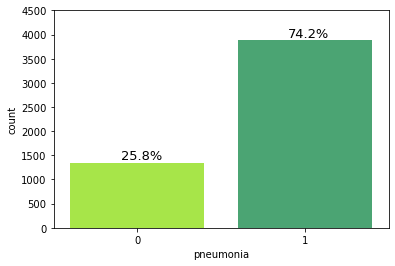

In [12]:
plt.figure()
pt= sns.countplot(data = df_train, x='pneumonia', palette=['greenyellow','mediumseagreen'])
plt.ylim(0, 4.5e3) # Adjust ylim for visualization purposes
for p in pt.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/len(df_train['pneumonia']))
   x = p.get_x() + p.get_width() / 2  - 0.1
   y = p.get_y() + p.get_height() 
   pt.annotate(percentage, (x, y), size = 13, va='bottom')
plt.show()

As observed, the majority of the cases in the training set have been diagnosed with pneumonia, representing nearly 75% of the data, whereas healthy patients represent around 25% of the cases.

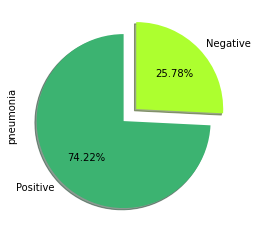

In [13]:
colors=['mediumseagreen', 'greenyellow']
df_train.pneumonia.value_counts().plot(kind='pie', startangle=90, explode=(0.1, 0.1), shadow=True, autopct='%1.2f%%', labels=['Positive','Negative'], colors= colors);

Let's take a look now to the images to have an idea how they look like:

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


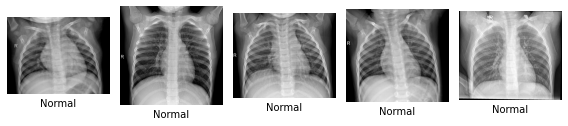

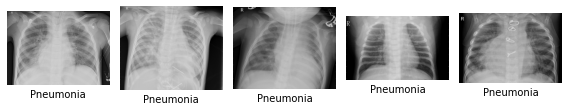

In [14]:
def make_plots(state):
    dataset = df_train.loc[df_train.loc[:,'pneumonia']==state, :].reset_index()
    print(type(dataset))
    plt.figure(figsize=(8, 10))
    for i in range(0,10):
        img = load_img(dataset['image'].iloc[i])
        plt.subplot(2, 5, i+1)
        plt.imshow(img)

        if dataset['pneumonia'].iloc[i] == 0:
            plt.xlabel('Normal')
        else:
            plt.xlabel('Pneumonia')

        # Selecting the axis-X making the bottom and top axes False.
        plt.tick_params(axis='x', which='both', bottom=False,
                    top=False, labelbottom=False)

        # Selecting the axis-Y making the right and left axes False
        plt.tick_params(axis='y', which='both', right=False,
                    left=False, labelleft=False)

        # Iterating over all the axes in the figure
        # and make the Spines Visibility as False
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)
        plt.tight_layout()

make_plots(0)
make_plots(1)

# 3. Data Preparation

In order for the model to be able to classify the cases into positive or negative pneumonia, we need to change the type of the diagnosis values from numerical values to strings:

In [15]:
df_train['pneumonia'] = df_train['pneumonia'].astype('str')
print(df_train.dtypes)

image        object
pneumonia    object
dtype: object


In [16]:
df_test['pneumonia'] = df_test['pneumonia'].astype('str')
print(df_test.dtypes)

image        object
pneumonia    object
dtype: object


We now set the image parameters. In this case, we consider images of size 256x256 pixels with one single gray scale channel. Additionally, we set the batch size which will be used in the CNN:

In [17]:
image_width=256
image_height=256
image_size=(image_width, image_height)
image_channels = 1
batch_size=32

In order to expand the training set, we generate additional images based on a series of transformations applied to the provided training images. ImageDataGenerator allow to define these transformations as rotations, zooming, horizontal flip etc. Additionally, the data is scaled taking into account that the maximum value of a pixel is 255. In this way, creating more training images will allow us to achieve better generalization of the model.

In [18]:
train_imggen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range = [0.5,1.5],  
    width_shift_range=0.1,
    height_shift_range=0.1)

We now define how the data is generated. As seen below, we apply the defined transformations to the training set where the images and target are found. Moreover, we set the target to be binary and the grayscale as color mode. In addition, we also specify the size of the image as an input. In this case, we set the directory to be none as the absolute paths are already specified in x_col, which corresponds to the image column of the training dataframe.

In [19]:
train_generator = train_imggen.flow_from_dataframe(
    df_train, 
    directory = None,
    x_col='image',
    y_col='pneumonia',
    target_size= image_size,
    class_mode='binary', # We only have positive/negative categories
    color_mode='grayscale',
    batch_size=batch_size)

Found 5232 validated image filenames belonging to 2 classes.


/home/nour/Documents/miniconda3/envs/ene/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In the case of the test data, we will only scale the pixels as we are using these images for validation and not for training.

In [20]:
valid_imggen  = ImageDataGenerator(rescale=1./255.)

In the same way as before, we specify the characteristics of the test set and we also apply the previous transformation.

In [21]:
validation_generator = valid_imggen.flow_from_dataframe(
    df_test, 
    directory=None,
    x_col='image',
    y_col='pneumonia',
    target_size=image_size,
    color_mode='grayscale',
    class_mode='binary', # We only have positive/negative categories
    batch_size=batch_size)

Found 624 validated image filenames belonging to 2 classes.


# 4. CNN Model

The next step is to generate the CNN model. To do so, one convolutional layer is created with eight filters of 7x7 kernel size and ReLU activation function for feature extration. Additionally, batch normalization is included to minimize unstable training behaviour. Moreover, maximum pooling is applied in the previously generated feature map in order to enhance these features by condensing the image based on the most active pixels. Finally, the flatten layer converts the previous outputs to one dimensional inputs required in the classifier head. The classifier onsist of the previously mentioned input layer with six units and one output layer with one binary unit, as we only have two categories (positive and negative pneumonia) to classify. To that end, sigmoid function is used in the last step. 

In this case, we aim to keep our model as simple as possible. This is because adding complexity has been observed to increase overfitting and therefore decreasing the model's ability to properly perform in new data. In other words, overfitting reduces its generalizability outside the original training set of images.

In [22]:
model = Sequential()
model.add(Conv2D(8, (7,7), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(6, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

Adaptive Moment Estimation (ADAM) optimizer is used to compile the model. The objective in this case is to minimize loss function of binary cross entropy. In addition, a series of metrics to be evaluated by the model when running are set.

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

Additionally, early stopping callback is added to the model in order to stop the training if the validation loss starts to diverge with further iterations. In this case, a minimum of 3 epochs is set before the model stops and the best weights achieved are restored.

In [25]:
earlystop = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss', mode='min')
callbacks = [earlystop]

Finally, we set the number of epochs and we run the model. Epochs value represents the number of times the model will run through the whole dataset if no early stopping occurs.

In [26]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=df_test.shape[0]//batch_size,
    steps_per_epoch=df_train.shape[0]//batch_size,
    callbacks=callbacks)

In case we previously saved our model we run the following cell instead of the previous one:

In [27]:
#model = keras.models.load_model('./my_model_CNN')

# 5. Model Validation

It is important to understand the metrics we are using to properly assess the performace of the model. In this case, we are using accuracy, recall, precision and AUC so we can obtain a better insight of our model. These metrics will be explained below. Let's first clarify some terms we are looking at:

*True Positives (TP): the portion of the model which was predicted as positive and whose target was actually positive, that is, portion of positive cases which were correctly predicted. 

*False Positives (FP): the portion of the model which was predicted as positive and whose target was actually negative, that is, portion of negative cases which were incorrectly predicted. 

*False Negatives (FN): the portion of real positive cases which were wrongly classified as negative.

*True Negatives (TN): the portion of real negative cases which were correctly classified as negative.

The confusion matrix illustrates these terms in a easly way:

<img src='./confusionMatrix.png'  align = 'center'>

We now load the output obtained from the run:

In [28]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('./history_log.csv', index=False)
#history_df = pd.read_csv('./history.csv')

A function is created to graphically showcase the output:

In [29]:
def make_plots_metrics(metric, color_list):
    sns.lineplot(y = metric, x = history_df.index, data=history_df, lw = 2, color = color_list[0])
    sns.lineplot(y = 'val_'+ metric, x = history_df.index, data=history_df, lw = 2, color = color_list[1])
    plt.ylabel(metric.capitalize());
    plt.title(metric.capitalize());
    plt.xlabel('Epochs');
    plt.legend(labels=['Training '+ metric, 'Validation '+ metric]);
    return plt.gca()

## 5.1. Loss

We first look at the binary cross-entropy loss which we aimed to minimize. As observed, a low value is achieved in both cases. 

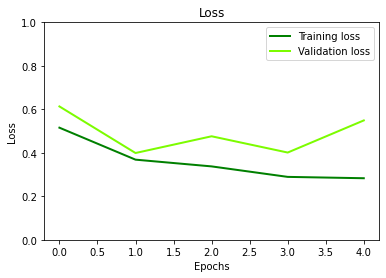

In [31]:
color_list = ['green', 'lawngreen']
ax = make_plots_metrics('loss', color_list)
ax.set_ylim([0,1]);

## 5.2. Accuracy

The accuracy metric represents the ratio of correct predictions to the total number of samples. Despite the fact it is intuitive to think that higher accuracy undoubtely implies that our model presents a good performance, it does not necessarily mean that. The reason for this is that we can have a non-even distribution of the target classes such as in this case. As previously mentioned, positive pneumonia cases represents most of the training data whereas negative healthy cases only account for 25% of the data. Therefore, achieving a high accuracy would be mainly affected by how well the positive cases are predicted. If our model does not properly identify the negative cases this would not be clearly reflected by the accuracy.

The formula of accuracy metric is:

$Accuracy = \frac{True\:Positives + True\:Negatives}{True\:Positives + False \:Negatives + True\:Negatives + False \:Positives} $

Looking at the accuracy results, we can see that the training set achieves nearly 90% of accuracy whereas the validation set reach accuracy values above 70%.

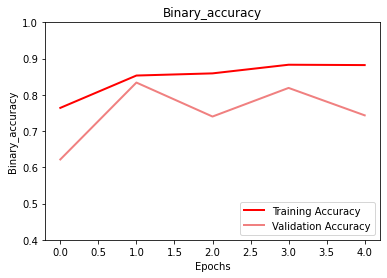

In [33]:
color_list = ['red', 'lightcoral']
ax = make_plots_metrics('binary_accuracy', color_list)
ax.set_ylim([0.4,1]);
ax.legend(labels = ['Training Accuracy', 'Validation Accuracy'],loc='lower right');

## 5.3. Recall

Recall metric represents the proportion of actual positives which was correctly identified. This metric is highly revelant as we aim to identify as much pneumonia cases as there actually are. In this case as in many diseases, we do not want to lose what could be a postivive diagnosis as the risk of missing it is quite dangerous, so we would prefer to be convervative in this sense.

The formula of recall metric is:

$Recall = \frac{True\:Positives}{True\:Positives + False \:Negatives} $

In this case we want the recall metric to be as high as possible, which would mean we are not missing so many true positive pneumonia cases. Achieving no false negatives would imply that our model has a recall of 1.0.

As observed in the figure below, satisfactory recall values above 0.9 were obtained in both the training and validation sets. Achieving a recall of 0.9 means that our model correctly identifies 90% of real pneumonia cases, which is considerably good. Additionally, it means that the number of false negatives is low.

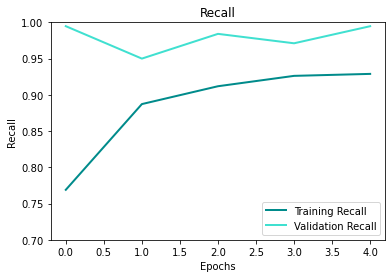

In [34]:
color_list = ['darkcyan', 'turquoise']
ax = make_plots_metrics('recall', color_list)
ax.set_ylim([0.7,1]);
ax.legend(labels = ['Training Recall', 'Validation Recall'],loc='lower right');

## 5.4. Precision

Precision however, represents the proportion of predicted positive cases which were actually positive. 

The formula of precision metric is:

$Precision = \frac{True\:Positives}{True\:Positives + False \:Positives} $

As deduced, no false positives would imply a precision of 1.0. In this case, this metric allow us to know more about our CNN performace, however it is less crucial compared to recall metric for the reasons previously mentioned. 

As seen in the following figure, precision around 0.9 was obtained for the training set whereas values around 0.7 were obtained for the validation set. Having a precision around 0.7 means that when our model predicts pneumonia, it is correct 70% of the time. 

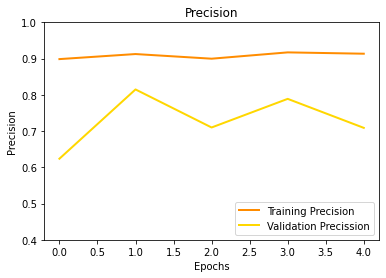

In [35]:
color_list = ['darkorange', 'gold']
ax = make_plots_metrics('precision', color_list)
ax.set_ylim([0.4,1]);
ax.legend(labels = ['Training Precision', 'Validation Precission'],loc='lower right');

## 5.5. AUC

AUC or "Area Under the Curve" is a measure of the area underneath the entire ROC curve. The ROC or "Receiver Operating Characteristic" curve plots the true positives TP versus the false positives FP obtained for different classification thresholds. AUC allows to evaluate how well the model is able to distinguish between the classes. The higher the AUC, the better the model is at distinguishing between positive and negative pneumonia cases. AUC value of 1.0 is the maximum value possible, which would mean the model is perfectly capable of identifying the disease, whereas a value of 0.0 would mean the model is not able to provide the correct dianosis at all. Furthermore, one of the main advantages of AUC is therefore the classification-threshold invariability,as it measures the performance of our model irrespective of the chosen classification threshold.

As observed in the obtained results, high AUC values above 0.9 were achieved in both sets which implies that our model presents a satisfactory performance in terms of pneumonia disease classification.

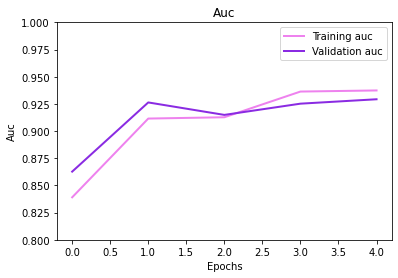

In [37]:
color_list = ['violet', 'blueviolet']
ax = make_plots_metrics('auc', color_list)
ax.set_ylim([0.8,1]);